Import all necessary libraries and install everything you need for training:

In [1]:
# install the libraries necessary for data wrangling, prediction and result analysis
import json
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score,precision_score, recall_score
import torch
from numba import cuda
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

In [2]:
# Install transformers
# (this needs to be done on Kaggle each time you start the session)
#!pip install -q transformers

In [2]:
# Install the simpletransformers
#!pip install -q simpletransformers
from simpletransformers.classification import ClassificationModel

In [4]:
# Install wandb
#!pip install -q wandb

In [3]:
import wandb

In [4]:
# Login to wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tajak (use `wandb login --relogin` to force relogin)


True

In [5]:
# Clean the GPU cache

cuda.select_device(0)
cuda.close()
cuda.select_device(0)
torch.cuda.empty_cache()


### Import the data

In [6]:
# CORE-main (texts annotated with main CORE labels)
train_df = pd.read_csv("data-splits/CORE-main-subset-train.csv", index_col = 0)
dev_df = pd.read_csv("data-splits/CORE-main-subset-dev.csv", index_col = 0)
test_df = pd.read_csv("data-splits/CORE-main-subset-test.csv", index_col = 0)

print("CORE-main train shape: {}, Dev shape: {}, Test shape: {}.".format(train_df.shape, dev_df.shape, test_df.shape))

CORE-main train shape: (10256, 2), Dev shape: (3419, 2), Test shape: (3419, 2).


In [7]:
train_df.head()

,text,labels
38864,I have never been able to ejaculate inside any...,Interactive Discussion
22351,Testimonials We have had the privilege of find...,Interactive Discussion
24938,"Saturday, November 03, 2012 Every time I check...",Narrative
39572,Why Didn't Nokia Use Android? Because That Wou...,Narrative
4574,A veterinarian specialising in wild horse immu...,Narrative


## Testing

We will use the multilingual XLM-RoBERTa model
https://huggingface.co/xlm-roberta-base

In [8]:
# Create a file to save results into (you can find it under Data: Output). Be careful, run this step only once to not overwrite the results file.
results = []

with open("results/CORE-main-Experiments-Results.json", "w") as results_file:
    json.dump(results,results_file, indent= "")

In [8]:
# Open the main results file:

previous_results_file = open("results/CORE-main-Experiments-Results.json")
previous_results = json.load(previous_results_file)
len(previous_results)

0

In [9]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [10]:
# Create a list of labels
LABELS = train_df.labels.unique().tolist()
LABELS

['Interactive Discussion',
 'Narrative',
 'Informational Description/Explanation',
 'Lyrical',
 'Opinion',
 'Informational Persuasion',
 'Spoken',
 'How-To/Instructional',
 'Other']

In [11]:
# Initialize Wandb
run = wandb.init(project="CORE-hyperparameter-search", entity="tajak", name="testing-trained-model")

In [8]:
# Load the saved model
#artifact = run.use_artifact('tajak/CORE-hyperparameter-search/CORE-main-classifier:v0', type='model')
#artifact_dir = artifact.download()

# Loading a local save
model = ClassificationModel(
    "xlmroberta", "artifacts/CORE-main-classifier:v0")

/home/tajak/anaconda3/lib/python3.9/site-packages/simpletransformers/classification/classification_model.py:459: UserWarning: use_multiprocessing automatically disabled as xlmroberta fails when using multiprocessing for feature conversion.
  warnings.warn(


In [14]:
def testing(test_df, test_name):
    """
    This function takes the test dataset and applies the trained model on it to infer predictions.
    It also prints and saves a confusion matrix, calculates the F1 scores and saves the results in a list of results.

    Args:
    - test_df (pandas DataFrame)
    - test_name
    """
    # Get the true labels
    y_true = test_df.labels
    
    # Calculate the model's predictions on test
    def make_prediction(input_string):
        return model.predict([input_string])[0][0]

    y_pred = test_df.text.apply(make_prediction)
    test_df["y_pred_CORE_main"] = y_pred

    # Calculate the scores
    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS,  average="micro")
    print(f"Macro f1: {macro:0.3}, Micro f1: {micro:0.3}")

    # Plot the confusion matrix:
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    plt.figure(figsize=(9, 9))
    plt.imshow(cm, cmap="Oranges")
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, '{:d}'.format(z), ha='center', va='center')
    classNames = LABELS
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=90)
    plt.yticks(tick_marks, classNames)
    plt.title(f"{test_name}")

    plt.tight_layout()
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig(f"figures/Confusion-matrix-{test_name}.png",dpi=100)

    # Save the results:
    rezdict = {
        "experiment": test_name,
        "num_train_epochs": 4,
        "train_batch_size":8,
        "learning_rate": 1e-5,
        "microF1": micro,
        "macroF1": macro,
        "y_true": y_true.to_dict(),
        "y_pred": y_pred.to_dict(),
        }
    previous_results.append(rezdict)

    #Save intermediate results (just in case)
    backup = []
    backup.append(rezdict)
    with open(f"backup-results-{test_name}.json", "w") as backup_file:
        json.dump(backup,backup_file, indent= "")

    # Save the new dataframe which contains the y_pred values as well
    test_df.to_csv(f"results/{test_name}-sheet-with-predictions.csv", sep="\t")

Macro f1: 0.623, Micro f1: 0.736


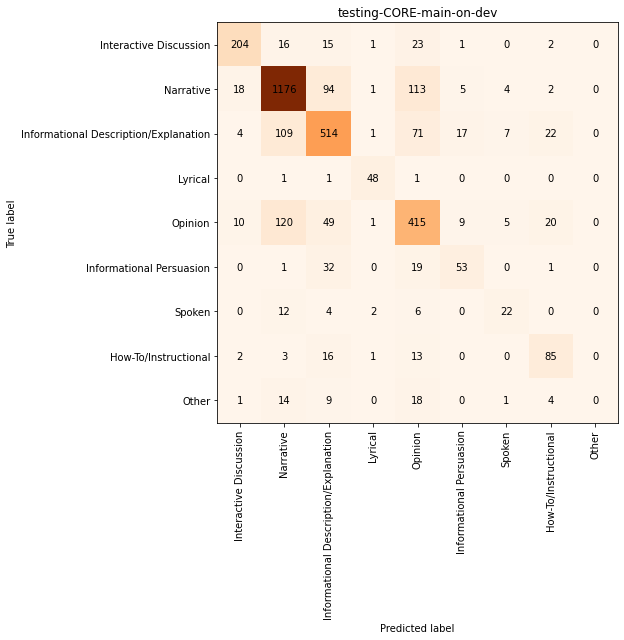


Testing finished.


<Figure size 432x288 with 0 Axes>

In [15]:
testing(dev_df, "testing-CORE-main-on-dev")

print("\nTesting finished.")

Macro f1: 0.62, Micro f1: 0.745


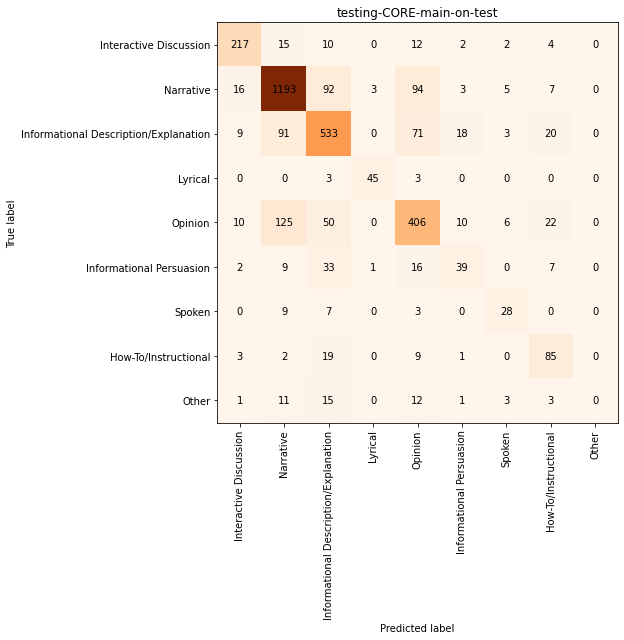


Testing finished.


<Figure size 432x288 with 0 Axes>

In [16]:
testing(test_df, "testing-CORE-main-on-test")
print("\nTesting finished.")

In [17]:
# Compare the results by creating a dataframe from the previous_results dictionary:
results_df = pd.DataFrame(previous_results)

results_df

,experiment,num_train_epochs,train_batch_size,learning_rate,microF1,macroF1,y_true,y_pred
0,testing-CORE-main-on-dev,4,8,0.00001,0.736180,0.623031,"{6282: 'Narrative', 7725: 'Narrative', 18967: ...","{6282: 'Narrative', 7725: 'Narrative', 18967: ..."
1,testing-CORE-main-on-test,4,8,0.00001,0.744662,0.620480,{32898: 'Informational Description/Explanation...,{32898: 'Informational Description/Explanation...


In [18]:
# Save the file with updated results.
with open("results/CORE-main-Experiments-Results.json", "w") as results_file:
    json.dump(previous_results,results_file, indent= "")

## Predict CORE labels to other datasets

In [9]:
# Create a function to predict
def predict_CORE(df, new_file_name):
    """
    This function takes a dataset and applies the trained model on it to infer predictions.
	It returns and saves the resulting df with added columns with CORE predictions.

    Args:
    - df: dataframe on which we want to apply prediction. The text should be in a column "text".
    - new_file_name: define the name of the new file
    """
    # Predict on the df
    def make_prediction(input_string):
        return model.predict([input_string])[0][0]

    y_pred = df.text.apply(make_prediction)

    df["CORE_main_pred"] = y_pred

    # Save the new dataframe which contains the y_pred values as well
    df.to_csv(f"{new_file_name}", sep="\t")

    return df

Prediction takes around 22 minutes per 1000 instances.

### Predict CORE to GINCO

In [10]:
# Import data about GINCO
ginco_df = pd.read_csv("GINCO-MT-GINCO-keeptext-with-all-information.csv", sep="\t", index_col=0)
ginco_df

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,...,GINCORE,text,MT_text,text_length,FTD_pred_on_SL,FTD_pred_on_MT,split-without-rare-categories,primary_level_4,downcast_split,CORE_main_pred
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,News,"Šport <p/> Zimska liga malega nogometa sobota,...",Sport <p/> Winter Little League Football Satur...,93,A8 (news),A8 (news),test,News/Reporting,test,Narrative
1,3726,http://www.ss-sezana.si/sss/index.php?option=c...,2014,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,...,Information/Explanation,JEDILNIK <p/> Iskalnik <p/> Poglavitni cilj pr...,JEDILNIK <p/> Search <p/> The main objective o...,76,A16 (information),A16 (information),test,Information/Explanation,dev,Informational Description/Explanation
2,5621,http://www.kamnik-starejsi.si/novice/144-sodel...,2014,False,Promotion of Services,Promotion of Services,Promotion,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,...,Promotion,Projekt INNOVAge in zavod Oreli <p/> Zavod Ore...,Project INNOVAge and the Oreli Institute <p/> ...,232,A12 (promotion),A12 (promotion),train,Promotion,test,Informational Description/Explanation
3,3776,http://www.radiocelje.si/novica.php?id=13007&a...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,News,"V novembru, mesecu preprečevanja odvisnosti, b...","In November, the month of addiction prevention...",158,A8 (news),A8 (news),train,News/Reporting,train,Informational Description/Explanation
4,2102,http://www.mtv.si/novice/selena-gomez-ponudila...,2014,False,Opinionated News,Opinionated News,Opinionated News,NaN,NaN,NaN,...,News,Selena Gomez ponudila v poslušanje novi album ...,Selena Gomez launches new album <p/> 16.07.201...,63,A8 (news),A8 (news),test,News/Reporting,train,Narrative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,374730,http://khetanes.si/sl-si/produkti/projektne-no...,2021,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,...,Information/Explanation,Projektne novine <p/> Promocijski projektni ča...,Project News <p/> Promotional project newspape...,86,A12 (promotion),A8 (news),test,Information/Explanation,test,Informational Description/Explanation
998,476885,https://www.merkur.si/navigacija/nasveti/kopal...,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,...,List of Summaries/Excerpts,V raznoliki ponudbi tušev izberite popolno raz...,Choose the perfect shower to match your taste ...,50,A12 (promotion),A12 (promotion),train,List of Summaries/Excerpts,train,Informational Persuasion
999,674213,http://www.sex2.si/category/ocene-izdelkov/,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,...,List of Summaries/Excerpts,"O izdelku Za znamko Dame stojita dve ženski, z...",About the product There are two women behind t...,295,A12 (promotion),A12 (promotion),train,List of Summaries/Excerpts,train,Informational Persuasion
1000,975590,http://www.ipsos.si/VodenjeVIZ_VI_past_dvojne_...,2021,False,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,NaN,NaN,NaN,...,Opinion/Argumentation,Razprava pogosto potegne na plano najprej tist...,The debate often brings to the surface first t...,409,A1 (argumentative),A1 (argumentative),dev,Opinion/Argumentation,train,Informational Description/Explanation


In [21]:
# First, use the Slovene data - rename the column with slovene text to "text"
ginco_df = ginco_df.rename(columns= {"Slovene_text": "text"})
ginco_df.head(1)

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,...,domain,GINCORE,text,MT_text,text_length,FTD_pred_on_SL,FTD_pred_on_MT,split-without-rare-categories,primary_level_4,downcast_split
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,www.pomurje.si,News,"Šport <p/> Zimska liga malega nogometa sobota,...",Sport <p/> Winter Little League Football Satur...,93,A8 (news),A8 (news),test,News/Reporting,test


In [22]:
# Apply predictions
ginco_df = predict_CORE(ginco_df, "GINCO-MT-GINCO-keeptext-with-all-information.csv")

In [ ]:
ginco_df

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,tertiary_level_1,tertiary_level_2,tertiary_level_3,split,domain,GINCORE,text,MT-text,text_length,FTD_pred
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,NaN,NaN,NaN,test,www.pomurje.si,News,"Šport <p/> Zimska liga malega nogometa sobota,...",Sport <p/> Winter Little League Football Satur...,93,A8 (news)
1,3726,http://www.ss-sezana.si/sss/index.php?option=c...,2014,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,NaN,NaN,NaN,train,www.ss-sezana.si,Information/Explanation,JEDILNIK <p/> Iskalnik <p/> Poglavitni cilj pr...,JEDILNIK <p/> Search <p/> The main objective o...,76,A16 (information)
2,5621,http://www.kamnik-starejsi.si/novice/144-sodel...,2014,False,Promotion of Services,Promotion of Services,Promotion,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,Information/Explanation,Information/Explanation,Information/Explanation,train,www.kamnik-starejsi.si,Promotion,Projekt INNOVAge in zavod Oreli <p/> Zavod Ore...,Project INNOVAge and the Oreli Institute <p/> ...,232,A12 (promotion)
3,3776,http://www.radiocelje.si/novica.php?id=13007&a...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,NaN,NaN,NaN,train,www.radiocelje.si,News,"V novembru, mesecu preprečevanja odvisnosti, b...","In November, the month of addiction prevention...",158,A8 (news)
4,2102,http://www.mtv.si/novice/selena-gomez-ponudila...,2014,False,Opinionated News,Opinionated News,Opinionated News,NaN,NaN,NaN,NaN,NaN,NaN,test,www.mtv.si,News,Selena Gomez ponudila v poslušanje novi album ...,Selena Gomez launches new album <p/> 16.07.201...,63,A8 (news)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,374730,http://khetanes.si/sl-si/produkti/projektne-no...,2021,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,Promotion of a Product,Promotion of a Product,Promotion,train,khetanes.si,Information/Explanation,Projektne novine <p/> Promocijski projektni ča...,Project News <p/> Promotional project newspape...,86,A12 (promotion)
998,476885,https://www.merkur.si/navigacija/nasveti/kopal...,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,NaN,NaN,NaN,train,www.merkur.si,List of Summaries/Excerpts,V raznoliki ponudbi tušev izberite popolno raz...,Choose the perfect shower to match your taste ...,50,A12 (promotion)
999,674213,http://www.sex2.si/category/ocene-izdelkov/,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,NaN,NaN,NaN,train,www.sex2.si,List of Summaries/Excerpts,"O izdelku Za znamko Dame stojita dve ženski, z...",About the product There are two women behind t...,295,A12 (promotion)
1000,975590,http://www.ipsos.si/VodenjeVIZ_VI_past_dvojne_...,2021,False,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,NaN,NaN,NaN,NaN,NaN,NaN,train,www.ipsos.si,Opinion/Argumentation,Razprava pogosto potegne na plano najprej tist...,The debate often brings to the surface first t...,409,A1 (argumentative)


In [11]:
# Let's also apply the predictions to the MT GINCO set
ginco_df = ginco_df.rename(columns={"text":"Slovene_text", "CORE_main_pred":"CORE_main_pred_on_SL"})
ginco_df = ginco_df.rename(columns={"MT_text":"text"})

In [12]:
ginco_df.head(1)

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,...,GINCORE,Slovene_text,text,text_length,FTD_pred_on_SL,FTD_pred_on_MT,split-without-rare-categories,primary_level_4,downcast_split,CORE_main_pred_on_SL
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,News,"Šport <p/> Zimska liga malega nogometa sobota,...",Sport <p/> Winter Little League Football Satur...,93,A8 (news),A8 (news),test,News/Reporting,test,Narrative


In [13]:
ginco_df = predict_CORE(ginco_df, "GINCO-MT-GINCO-keeptext-with-all-information-2.csv")

In [14]:
ginco_df

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,...,Slovene_text,text,text_length,FTD_pred_on_SL,FTD_pred_on_MT,split-without-rare-categories,primary_level_4,downcast_split,CORE_main_pred_on_SL,CORE_main_pred
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,"Šport <p/> Zimska liga malega nogometa sobota,...",Sport <p/> Winter Little League Football Satur...,93,A8 (news),A8 (news),test,News/Reporting,test,Narrative,Narrative
1,3726,http://www.ss-sezana.si/sss/index.php?option=c...,2014,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,...,JEDILNIK <p/> Iskalnik <p/> Poglavitni cilj pr...,JEDILNIK <p/> Search <p/> The main objective o...,76,A16 (information),A16 (information),test,Information/Explanation,dev,Informational Description/Explanation,Informational Description/Explanation
2,5621,http://www.kamnik-starejsi.si/novice/144-sodel...,2014,False,Promotion of Services,Promotion of Services,Promotion,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,...,Projekt INNOVAge in zavod Oreli <p/> Zavod Ore...,Project INNOVAge and the Oreli Institute <p/> ...,232,A12 (promotion),A12 (promotion),train,Promotion,test,Informational Description/Explanation,Informational Description/Explanation
3,3776,http://www.radiocelje.si/novica.php?id=13007&a...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,"V novembru, mesecu preprečevanja odvisnosti, b...","In November, the month of addiction prevention...",158,A8 (news),A8 (news),train,News/Reporting,train,Informational Description/Explanation,Informational Description/Explanation
4,2102,http://www.mtv.si/novice/selena-gomez-ponudila...,2014,False,Opinionated News,Opinionated News,Opinionated News,NaN,NaN,NaN,...,Selena Gomez ponudila v poslušanje novi album ...,Selena Gomez launches new album <p/> 16.07.201...,63,A8 (news),A8 (news),test,News/Reporting,train,Narrative,Narrative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,374730,http://khetanes.si/sl-si/produkti/projektne-no...,2021,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,...,Projektne novine <p/> Promocijski projektni ča...,Project News <p/> Promotional project newspape...,86,A12 (promotion),A8 (news),test,Information/Explanation,test,Informational Description/Explanation,Informational Description/Explanation
998,476885,https://www.merkur.si/navigacija/nasveti/kopal...,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,...,V raznoliki ponudbi tušev izberite popolno raz...,Choose the perfect shower to match your taste ...,50,A12 (promotion),A12 (promotion),train,List of Summaries/Excerpts,train,Informational Persuasion,Informational Persuasion
999,674213,http://www.sex2.si/category/ocene-izdelkov/,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,...,"O izdelku Za znamko Dame stojita dve ženski, z...",About the product There are two women behind t...,295,A12 (promotion),A12 (promotion),train,List of Summaries/Excerpts,train,Informational Persuasion,Informational Persuasion
1000,975590,http://www.ipsos.si/VodenjeVIZ_VI_past_dvojne_...,2021,False,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,NaN,NaN,NaN,...,Razprava pogosto potegne na plano najprej tist...,The debate often brings to the surface first t...,409,A1 (argumentative),A1 (argumentative),dev,Opinion/Argumentation,train,Informational Description/Explanation,Informational Description/Explanation


In [15]:
# Let's save the final version
ginco_df = ginco_df.rename(columns={"text":"MT_text", "CORE_main_pred":"CORE_main_pred_on_MT"})

ginco_df.to_csv("data-sheets-with-all-info/GINCO-MT-GINCO-keeptext-with-all-information.csv", sep="\t")

In [ ]:
ginco_df

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,...,tertiary_level_2,tertiary_level_3,split,domain,GINCORE,Slovene_text,MT_text,text_length,FTD_pred_on_SL,FTD_pred_on_MT
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,NaN,NaN,test,www.pomurje.si,News,"Šport <p/> Zimska liga malega nogometa sobota,...",Sport <p/> Winter Little League Football Satur...,93,A8 (news),A8 (news)
1,3726,http://www.ss-sezana.si/sss/index.php?option=c...,2014,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,...,NaN,NaN,train,www.ss-sezana.si,Information/Explanation,JEDILNIK <p/> Iskalnik <p/> Poglavitni cilj pr...,JEDILNIK <p/> Search <p/> The main objective o...,76,A16 (information),A16 (information)
2,5621,http://www.kamnik-starejsi.si/novice/144-sodel...,2014,False,Promotion of Services,Promotion of Services,Promotion,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,...,Information/Explanation,Information/Explanation,train,www.kamnik-starejsi.si,Promotion,Projekt INNOVAge in zavod Oreli <p/> Zavod Ore...,Project INNOVAge and the Oreli Institute <p/> ...,232,A12 (promotion),A12 (promotion)
3,3776,http://www.radiocelje.si/novica.php?id=13007&a...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,NaN,NaN,train,www.radiocelje.si,News,"V novembru, mesecu preprečevanja odvisnosti, b...","In November, the month of addiction prevention...",158,A8 (news),A8 (news)
4,2102,http://www.mtv.si/novice/selena-gomez-ponudila...,2014,False,Opinionated News,Opinionated News,Opinionated News,NaN,NaN,NaN,...,NaN,NaN,test,www.mtv.si,News,Selena Gomez ponudila v poslušanje novi album ...,Selena Gomez launches new album <p/> 16.07.201...,63,A8 (news),A8 (news)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,374730,http://khetanes.si/sl-si/produkti/projektne-no...,2021,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,...,Promotion of a Product,Promotion,train,khetanes.si,Information/Explanation,Projektne novine <p/> Promocijski projektni ča...,Project News <p/> Promotional project newspape...,86,A12 (promotion),A8 (news)
998,476885,https://www.merkur.si/navigacija/nasveti/kopal...,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,...,NaN,NaN,train,www.merkur.si,List of Summaries/Excerpts,V raznoliki ponudbi tušev izberite popolno raz...,Choose the perfect shower to match your taste ...,50,A12 (promotion),A12 (promotion)
999,674213,http://www.sex2.si/category/ocene-izdelkov/,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,...,NaN,NaN,train,www.sex2.si,List of Summaries/Excerpts,"O izdelku Za znamko Dame stojita dve ženski, z...",About the product There are two women behind t...,295,A12 (promotion),A12 (promotion)
1000,975590,http://www.ipsos.si/VodenjeVIZ_VI_past_dvojne_...,2021,False,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,NaN,NaN,NaN,...,NaN,NaN,train,www.ipsos.si,Opinion/Argumentation,Razprava pogosto potegne na plano najprej tist...,The debate often brings to the surface first t...,409,A1 (argumentative),A1 (argumentative)


In [16]:
# Analyse in how many cases do the labels on SL and MT text differ
ginco_df["agreement"] = np.where((ginco_df["CORE_main_pred_on_SL"] != ginco_df["CORE_main_pred_on_MT"]), "no", "yes")

ginco_df.head(3)

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,...,MT_text,text_length,FTD_pred_on_SL,FTD_pred_on_MT,split-without-rare-categories,primary_level_4,downcast_split,CORE_main_pred_on_SL,CORE_main_pred_on_MT,agreement
0,3949,http://www.pomurje.si/aktualno/sport/zimska-li...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,Sport <p/> Winter Little League Football Satur...,93,A8 (news),A8 (news),test,News/Reporting,test,Narrative,Narrative,yes
1,3726,http://www.ss-sezana.si/sss/index.php?option=c...,2014,False,Information/Explanation,Information/Explanation,Information/Explanation,NaN,NaN,NaN,...,JEDILNIK <p/> Search <p/> The main objective o...,76,A16 (information),A16 (information),test,Information/Explanation,dev,Informational Description/Explanation,Informational Description/Explanation,yes
2,5621,http://www.kamnik-starejsi.si/novice/144-sodel...,2014,False,Promotion of Services,Promotion of Services,Promotion,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,...,Project INNOVAge and the Oreli Institute <p/> ...,232,A12 (promotion),A12 (promotion),train,Promotion,test,Informational Description/Explanation,Informational Description/Explanation,yes


In [17]:
ginco_df[ginco_df["agreement"] == "no"]

,id,url,crawled,hard,primary_level_1,primary_level_2,primary_level_3,secondary_level_1,secondary_level_2,secondary_level_3,...,MT_text,text_length,FTD_pred_on_SL,FTD_pred_on_MT,split-without-rare-categories,primary_level_4,downcast_split,CORE_main_pred_on_SL,CORE_main_pred_on_MT,agreement
10,9257,http://www.unicef.si/novice/204/unicef-ob-zace...,2014,False,News/Reporting,News/Reporting,News/Reporting,NaN,NaN,NaN,...,UNICEF boosts support for education in the Hor...,551,A1 (argumentative),A1 (argumentative),train,News/Reporting,train,Informational Description/Explanation,Narrative,no
11,8887,http://www.zadovoljna.si/forum?post_id=960155,2014,False,Forum,Forum,Forum,NaN,NaN,NaN,...,Rozka30 I agree about the White Masai. Good bo...,601,A17 (review),A11 (personal),train,Forum,train,Interactive Discussion,Opinion,no
13,9961,http://old.radiostudent.si/print.php?sid=30419...,2014,False,Opinionated News,Opinionated News,Opinionated News,NaN,NaN,NaN,...,A lesbian and feminist club in every village S...,956,A17 (review),A8 (news),train,News/Reporting,dev,Informational Description/Explanation,Narrative,no
21,1126,http://okolje.nakamniskem.si/?tag=sezigalnica,2014,False,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,NaN,NaN,NaN,...,Posts tagged 'incinerator' <p/> In the autumn ...,245,A1 (argumentative),A1 (argumentative),train,Opinion/Argumentation,train,Informational Description/Explanation,Narrative,no
31,6695,http://www.4me.si/otroci.html?tmpl=component&a...,2014,False,Opinion/Argumentation,Opinion/Argumentation,Opinion/Argumentation,Promotion of Services,Promotion of Services,Promotion,...,"When you receive a baby in your arms, it's lik...",153,A12 (promotion),A12 (promotion),train,Opinion/Argumentation,test,Informational Persuasion,Lyrical,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,24769936,"http://forum.zevs.si/index.php/topic,882.270.html",2021,False,Forum,Forum,Forum,NaN,NaN,NaN,...,"T=0°C and snowing, small to medium snowflakes ...",630,A11 (personal),A11 (personal),train,Forum,train,Interactive Discussion,Informational Description/Explanation,no
978,26071580,https://www.sonce-nepremicnine.si/sl/Nepremicn...,2021,False,Promotion of a Product,Promotion of a Product,Promotion,Information/Explanation,Information/Explanation,Information/Explanation,...,Detached house for sale <p/> Primorje-Gorski K...,119,A12 (promotion),A12 (promotion),dev,Promotion,test,Informational Description/Explanation,Informational Persuasion,no
988,33868957#1,http://splet.dc-dlan.si/teorija-spola/,2021,False,List of Summaries/Excerpts,List of Summaries/Excerpts,List of Summaries/Excerpts,NaN,NaN,NaN,...,Gender Theory Publications <p/> If you've ever...,381,A1 (argumentative),A1 (argumentative),dev,List of Summaries/Excerpts,train,Informational Description/Explanation,Spoken,no
992,36272232#1,https://modna.si/najlazji-in-najboljsi-nacin-c...,2021,False,Instruction,Instruction,Instruction,NaN,NaN,NaN,...,What you need: a plastic bag and a freezer. <p...,113,A7 (instruction),A7 (instruction),dev,Instruction,dev,Interactive Discussion,How-To/Instructional,no


The CORE predictions on Slovene and MT text differ in 182 instances (18%).

## Predict CORE to FTD

In [20]:
# Import data
ftd = pd.read_csv("data-sheets-with-all-info/FTD-dataset-with-all-information.csv", sep="\t", index_col = 0)

ftd

,ID,labels,Multiple labels,text,length,GINCO_downcast_pred,MT-GINCO_downcast_pred
0,__id__1-syndicate,A1 (argumentative),NaN,BMW's and Chinese Justice * * * * * In most pl...,975,News/Reporting,News/Reporting
1,__id__2-syndicate,A1 (argumentative),NaN,China and a New Balance of Power SHANGHAI – Th...,956,Information/Explanation,Opinion/Argumentation
2,__id__3-syndicate,A1 (argumentative),NaN,China and Russia in the New World Disorder Can...,978,Opinion/Argumentation,Opinion/Argumentation
3,__id__4-syndicate,A1 (argumentative),NaN,The Roots of Chinese / Japanese Rivalry BOSTON...,957,Opinion/Argumentation,Opinion/Argumentation
4,__id__5-syndicate,A1 (argumentative),NaN,China's Cyber-Warriors NEW DELHI – The world n...,1034,News/Reporting,News/Reporting
...,...,...,...,...,...,...,...
1681,__id__1682-britannica,A1 (argumentative),NaN,"In Eichmann in Jerusalem , Hannah Arendt descr...",610,Information/Explanation,Information/Explanation
1682,__id__1683-britannica,A16 (information),NaN,The vast expanse of the African continent span...,381,Information/Explanation,Information/Explanation
1683,__id__1684-britannica,A1 (argumentative),NaN,"Lance Corporal Samantha L. Jones , USMC Politi...",2482,Information/Explanation,Information/Explanation
1684,__id__1685-britannica,A12 (promotion),NaN,"Courtesy of the Victoria and Albert Museum , L...",390,Information/Explanation,Information/Explanation


In [21]:
ftd_predicted = predict_CORE(ftd, "FTD-dataset-with-all-information.csv")

ftd_predicted

,ID,labels,Multiple labels,text,length,GINCO_downcast_pred,MT-GINCO_downcast_pred,CORE_main_pred
0,__id__1-syndicate,A1 (argumentative),NaN,BMW's and Chinese Justice * * * * * In most pl...,975,News/Reporting,News/Reporting,Narrative
1,__id__2-syndicate,A1 (argumentative),NaN,China and a New Balance of Power SHANGHAI – Th...,956,Information/Explanation,Opinion/Argumentation,Opinion
2,__id__3-syndicate,A1 (argumentative),NaN,China and Russia in the New World Disorder Can...,978,Opinion/Argumentation,Opinion/Argumentation,Opinion
3,__id__4-syndicate,A1 (argumentative),NaN,The Roots of Chinese / Japanese Rivalry BOSTON...,957,Opinion/Argumentation,Opinion/Argumentation,Narrative
4,__id__5-syndicate,A1 (argumentative),NaN,China's Cyber-Warriors NEW DELHI – The world n...,1034,News/Reporting,News/Reporting,Narrative
...,...,...,...,...,...,...,...,...
1681,__id__1682-britannica,A1 (argumentative),NaN,"In Eichmann in Jerusalem , Hannah Arendt descr...",610,Information/Explanation,Information/Explanation,Narrative
1682,__id__1683-britannica,A16 (information),NaN,The vast expanse of the African continent span...,381,Information/Explanation,Information/Explanation,Informational Description/Explanation
1683,__id__1684-britannica,A1 (argumentative),NaN,"Lance Corporal Samantha L. Jones , USMC Politi...",2482,Information/Explanation,Information/Explanation,Narrative
1684,__id__1685-britannica,A12 (promotion),NaN,"Courtesy of the Victoria and Albert Museum , L...",390,Information/Explanation,Information/Explanation,Informational Description/Explanation
